<a href="https://colab.research.google.com/github/Rainbowpen/water_quality/blob/main/water_quality_linear_and_dnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Water Quality
### Drinking water potability
kaggle dataset learning by Simon Zheng

Kaggle water quality dataset web page: https://www.kaggle.com/adityakadiwal/water-potability/version/3

CSV file:
https://www.kaggle.com/adityakadiwal/water-potability/download

**most code copy from tensorflow website**

In [ ]:
%tensorflow_version 2.x  # this line is not required unless you are in a notebook

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # this line is not required unless you are in a notebook`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

Download dataset from https://www.kaggle.com/adityakadiwal/water-potability/download




In [ ]:
!ls

sample_data  water_potability.csv


In [ ]:
# Load dataset.
dataset = pd.read_csv('./water_potability.csv')

In [ ]:
dataset.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [ ]:
dataset.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


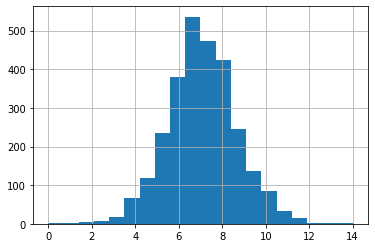

In [ ]:
dataset.ph.hist(bins=20)

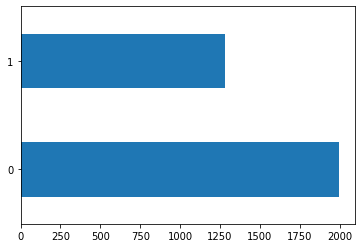

In [ ]:
dataset.Potability.value_counts().plot(kind='barh')

Some row is nan, need to drop it before continue

In [ ]:
dataset.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [ ]:
#dataset = dataset.dropna()
dataset.drop(['ph','Sulfate','Trihalomethanes'],axis=1,inplace=True)

In [ ]:
from sklearn.utils import shuffle
dataset = shuffle(dataset)

In [ ]:
dataset.shape

(3276, 7)

In [ ]:
dtrain = dataset[0 : int(dataset.shape[0] * 0.8)]
deval = dataset[int(dataset.shape[0] * 0.8) :]
y_train = dtrain.pop('Potability')
y_eval = deval.pop('Potability')

In [ ]:
dtrain.head()

,Hardness,Solids,Chloramines,Conductivity,Organic_carbon,Turbidity
911,214.172330,8985.911807,7.297973,498.803917,9.583323,5.504749
21,168.283747,30944.363591,5.858769,523.671298,17.884235,3.749701
408,196.615992,25740.412591,2.484380,352.353623,16.924419,4.498685
743,178.716633,33786.716309,9.101885,481.073539,12.273181,2.743867
505,207.065587,16544.275591,7.039311,278.753204,17.052540,4.117488


In [ ]:
NUMERIC_COLUMNS = [i for i in dtrain.columns]
print(NUMERIC_COLUMNS)

feature_columns = []
for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

print(feature_columns)

['Hardness', 'Solids', 'Chloramines', 'Conductivity', 'Organic_carbon', 'Turbidity']
[NumericColumn(key='Hardness', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Solids', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Chloramines', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Conductivity', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Organic_carbon', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='Turbidity', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]


In [ ]:
def make_input_fn(data_df, label_df, num_epochs=100, shuffle=True, batch_size=256):
  def input_function():  # inner function, this will be returned
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))  # create tf.data.Dataset object with data and its label
    if shuffle:
      ds = ds.shuffle(1000)  # randomize order of data
    ds = ds.batch(batch_size).repeat(num_epochs)  # split dataset into batches of 32 and repeat process for number of epochs
    return ds  # return a batch of the dataset
  return input_function  # return a function object for use

train_input_fn = make_input_fn(dtrain, y_train)  # here we will call the input_function that was returned to us to get a dataset object we can feed to the model
eval_input_fn = make_input_fn(deval, y_eval, num_epochs=1, shuffle=False)

In [ ]:
def input_fn(features, labels, training=True, batch_size=256):
    # Convert the inputs to a Dataset.
    input_dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))

    # Shuffle and repeat if you are in training mode.
    if training:
        input_dataset = input_dataset.shuffle(1000).repeat()
    
    return input_dataset.batch(batch_size)


In [ ]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
# We create a linear estimtor by passing the feature columns we created earlier

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpbpi9lzkg', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
# Build a DNN with 2 hidden layers with 30 and 10 hidden nodes each.
dnnclassifier = tf.estimator.DNNClassifier(
    feature_columns=feature_columns,
    # Two hidden layers of 30 and 10 nodes respectively.
    hidden_units=[30, 10],
    # The model must choose between 3 classes.
    n_classes=2)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp75qmlv6q', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
#linear
linear_est.train(train_input_fn)  # train
result = linear_est.evaluate(eval_input_fn)  # get model metrics/stats by testing on tetsing data
#clear_output()  # clears consoke output


#dnn
#dnnclassifier.train(
#    input_fn=lambda: input_fn(dtrain, y_train, training=True),
#    steps=500000)
# We include a lambda to avoid creating an inner function previously


INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpbpi9lzkg/model.ckpt-11000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 11000...
INFO:tensorflow:Saving checkpoints for 11000 into /tmp/tmpbpi9lzkg/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 11000...
INFO:tensorflow:loss = 8.840673, step = 11000
INFO:tensorflow:global_step/sec: 406.215
INFO:tensorflow:loss = 13.478387, step = 11100 (0.251 sec)
INFO:tensorflow:global_step/sec: 548.787
INFO:tensorflow:loss = 14.704209, step = 11200 (0.182 sec)
INFO:tensorflow:global_step/sec: 524.695
INFO:tensorflow:loss = 23.340141, step = 11300 (0.191 sec)
INFO:tensorflow:global_step/sec: 525.857
INFO:tensorflow:loss = 16.640072, step = 11400 (0.188 sec)
INFO:tensorflow:global_step/sec: 533.61

In [ ]:
#eval_result = dnnclassifier.evaluate(
#    input_fn=lambda: input_fn(deval, y_eval, training=False))
#print('\nTest set accuracy: {accuracy:0.3f}\n'.format(**eval_result))


print(result['accuracy'])  # the result variable is simply a dict of stats about our model

0.625


INFO:tensorflow:Calling model_fn.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1700: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpbpi9lzkg/model.ckpt-12100
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[{'logits': array([-33.334282], dtype=float32), 'logistic': array([3.3350726e-15], dtype=float32), 'probabilities': array([1.0000000e+00, 3.3350726e-15], dtype=float32), 'class_ids': array([0]), 'classes': array([b'0'], dtype=object), 'all_class_ids': array([0, 1], dtype=int32), 'all_classes': array([b'0', b'1'], dtype=object)}, {'logits': array([-19.384256], dtype=float32), 'logistic': array([3.8152628e-09], dtype=float32), 'probabilities': array([1.0000000e+00, 3.8152628e-09], dtype=float32), 'class_ids': array([0]), 'classes': array([b'0'], dtype=object), 'all_class_ids': array([0, 1], dtype=int32), 'all_classes': array([b'0', b'1'], dtype=object)}, {'logits': array([-29.262754], dtype=float32), 'logistic': array([1.9559026e-13], dtype=float32), 'proba

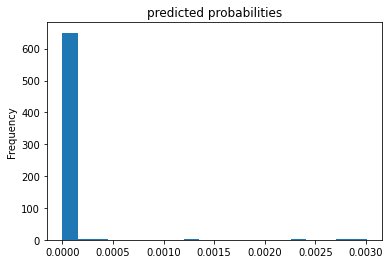

In [ ]:
pred_dicts = list(linear_est.predict(eval_input_fn))
#pred_dicts = list(dnnclassifier.predict(eval_result))
print(pred_dicts)
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')